In [ ]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import librosa, librosa.display

In [ ]:
def generate_spectrogram(sound_in, sr,img_out):
    
    y = sound_in
    S = librosa.feature.melspectrogram(y=y, sr=sr)

    plt.ioff()
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
    plt.axis('off') # Removes black border
    plt.tight_layout()
    plt.savefig(img_out,bbox_inches='tight',pad_inches=-0.05,transparency=True, format='jpg')
    #plt.clf() # clear figure to control memory problems
    #plt.close()
    
    del S,y,sr

# Generate content

In [ ]:
wav_out = "/Users/tmiano/Documents/Projects/cvr/me_drilling-sound_171128.wav"
img_out = "/Users/tmiano/Documents/Projects/cvr/me_drilling-sound_171128.jpg"

In [ ]:
sr=44100
duration = 4  # seconds
mic_recording = sd.rec(duration * sr, samplerate=sr, channels=2,dtype='float64')
print("Recording Audio")
sd.wait()
print("Audio recording complete , Play Audio")
sd.play(mic_recording, sr)
sd.wait()
print("Play Audio Complete")
wav.write(wav_out,sr,mic_recording)
print("Audio written.")

In [ ]:
generate_spectrogram(mic_recording[:,0],sr,img_out)

# Review recordings

In [ ]:
wav_out = "/Users/tmiano/Documents/Projects/cvr/me_barking_171128.wav"
sr, myrecording = wav.read(wav_out)

# Live rendering

In [ ]:
# !pip install pygtk # doesn't work https://stackoverflow.com/questions/1164949/where-is-pygtk-for-mac-os-x

In [24]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav

import matplotlib
# matplotlib.use('GTKAgg')
import matplotlib.pyplot as plt
%matplotlib inline

import librosa, librosa.display

In [26]:
# plt.ion()

sr=44100
duration = 1  # seconds
stream_time = 5

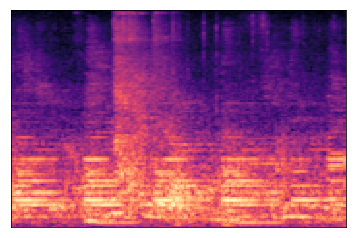

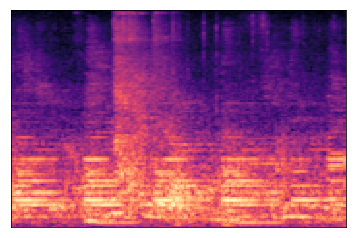

In [27]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

duration = 2.0

for i in range(3):
    
    mic_recording = sd.rec(int(duration) * sr, samplerate=sr, channels=2,dtype='float64')
    sd.wait()
    stream_spectrogram(mic_recording[:,0],sr)
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.0001)
#display.clear_output()

In [45]:
import torch
import torchvision.models as models
resnet = models.resnet50(pretrained = True)
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms

In [46]:
print(resnet.fc)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
print(resnet.fc)

Linear (2048 -> 1000)
Linear (2048 -> 10)


In [47]:
resnet.load_state_dict(torch.load('../../../data/resnet50_v2_melspect_15_968.pt',
                                         map_location=lambda storage, 
                                         loc: storage
                                        )
                             )

transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

In [166]:
import torch.nn.functional as F

def classify_sound(image,resnet):
    
    resnet.eval()

    # Try your own image here.
    inputVar =  Variable(transform(image).unsqueeze(0))
    predictions = resnet(inputVar.cpu())

    probs, indices = (-F.softmax(predictions.cpu())).data.sort()
    probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
    preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]
    #print(preds)
    #plt.title('\n'.join(preds))
    #plt.imshow(image);
    return preds

In [156]:
# from io import StringIO
from io import BytesIO
import PIL

def stream_spectrogram(sound_in, sr):
    
    y = sound_in
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    buffer_ = BytesIO()
    
    plt.ioff()
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
    plt.axis('off') # Removes black border
    plt.tight_layout()
    #plt.close()
    plt.savefig(buffer_,bbox_inches='tight',pad_inches=-0.05,transparency=True, format='jpg')
    image = PIL.Image.open(buffer_)
    plt.close()
    buffer_.seek(0)
    #ar = np.asarray(image)
    return image
    buffer_.close()
    #del S,y,sr

In [157]:
img = stream_spectrogram(mic_recording[:,0],sr)

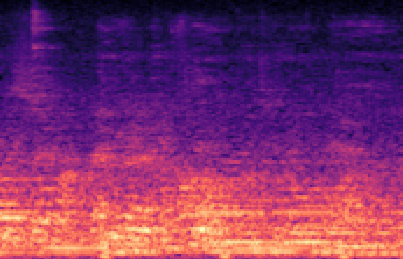

In [163]:
img

In [165]:
class_dict = {0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jack_hammer',
 8: 'siren',
 9: 'street_music'}
classify_sound(img,resnet)

['street_music: 0.998356', 'dog_bark: 0.00061008', 'drilling: 0.000407914', 'air_conditioner: 0.000182007', 'gun_shot: 0.000174556', 'children_playing: 0.000164186', 'jack_hammer: 4.09639e-05', 'car_horn: 3.74642e-05', 'engine_idling: 2.21386e-05', 'siren: 4.4216e-06']


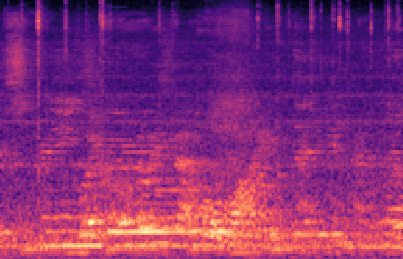

['street_music: 0.999932',
 'air_conditioner: 4.46747e-05',
 'drilling: 1.14643e-05',
 'gun_shot: 5.33789e-06',
 'dog_bark: 2.79455e-06',
 'car_horn: 1.7812e-06',
 'children_playing: 1.71688e-06',
 'engine_idling: 1.87443e-07',
 'jack_hammer: 1.78506e-07',
 'siren: 1.20573e-07']

In [236]:
# 3 seconds does a pretty good job. You should evaluate quantitatively!
duration = 3

for i in range(30):
    
    try:
        display.clear_output(wait=True)
        
        mic_recording = sd.rec(int(duration * sr), samplerate=sr, channels=2,dtype='float64')
        sd.wait()
        spect = stream_spectrogram(mic_recording[:,0],sr)
        preds = classify_sound(spect,resnet)
        
        display.display(spect)
        display.display(preds)
        
        time.sleep(.0001)
    except KeyboardInterrupt:
        break

In [ ]:
# edit deepdream.py
# X_Variable = Variable(X_tensor.cuda(), requires_grad=True)